<a href="https://colab.research.google.com/github/TaibatNofiu/lending_club-accept/blob/main/Data_Visualization_and_Model_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import necessary libraries to perform

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
accepted_data = pd.read_csv("/content/drive/MyDrive/GMC/accepted_2007_to_2018Q4.csv.gz", compression = 'gzip', low_memory= False)
accepted_data.shape

(2260701, 151)

In [ ]:
accepted_data.columns.tolist()

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 '

##2. Data Cleaning


*   Reduce the columns size of accepted data by dropping columns with missing values higher than 60%
*   Use the zip_code column to add `region` column to the dataset
*   Add a new column (status) using the `loan_status` column, this is to know the loans that were repaid and defaulted
*   Change the date type from object to datatime type





In [ ]:
## Add a column that use zip_code to define region
# Map first digit to region
region_map = {
    '0': 'Northeast',
    '1': 'Mid-Atlantic',
    '2': 'Mid-Atlantic & Southeast',
    '3': 'Southeast',
    '4': 'Midwest',
    '5': 'Upper Midwest',
    '6': 'Central',
    '7': 'South Central',
    '8': 'Mountain',
    '9': 'West / Pacific'
}

# Use map with the first character of zip_code
accepted_data['region'] = accepted_data['zip_code'].str[0].map(region_map)

In [ ]:
len(accepted_data)

2260701

In [ ]:
# Check for the missing values in descending order
missing_values = accepted_data.isna().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
missing_values

,0
member_id,2260701
orig_projected_additional_accrued_interest,2252050
hardship_status,2249784
hardship_amount,2249784
hardship_last_payment_amount,2249784
...,...
total_rec_late_fee,33
total_rec_int,33
disbursement_method,33
hardship_flag,33


In [ ]:
# Create a minimum and maximum threshold to drop the missing columns
low = 0.3 * len(accepted_data)
high = 2260701

columns_to_drop = missing_values[(missing_values >= low) & (missing_values <= high)].index
accepted_cleaned = accepted_data.drop(columns=columns_to_drop, axis = 1)
accepted_cleaned.shape

(2260701, 94)

In [ ]:
accepted_cleaned['loan_status'].value_counts()

,count
loan_status,
Fully Paid,1076751
Current,878317
Charged Off,268559
Late (31-120 days),21467
In Grace Period,8436
Late (16-30 days),4349
Does not meet the credit policy. Status:Fully Paid,1988
Does not meet the credit policy. Status:Charged Off,761
Default,40


The `loan_status` shows the people that repaid their loan and those that defaulted

We can a new column named status to show the people that repaid and those that defaulted using the `loan_status` column

In [ ]:
# Create a new column using the loan_status, nan remains nan
loan_mapping = {
    'Fully Paid': 1,
    'Charged Off': 0,
    'Current': 1,
    'Late (31-120 days)': 0,
    'In Grace Period': 0,
    'Late (16-30 days)': 0,
    'Default': 0,
    'Does not meet the credit policy. Status:Fully Paid': 1,
    'Does not meet the credit policy. Status:Charged Off': 0,
    }

accepted_cleaned['status'] = accepted_cleaned['loan_status'].map(loan_mapping)
accepted_cleaned['status'].value_counts()

,count
status,
1.0,1957056
0.0,303612


In [ ]:
# Create a new column named status_label using the status column: the rows are named default and no default
accepted_cleaned['status_label'] = accepted_cleaned['status'].apply(lambda x: 'default' if x == 0 else 'no default')
accepted_cleaned['status_label'].value_counts()

,count
status_label,
no default,1957089
default,303612


In [ ]:
# Employment length mapping
employment_length_mapping = {
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10,
    '< 1 year': 0.5,
    'n/a': 0
}

# Apply the mapping to the 'emp_length' column
accepted_cleaned['emp_length'] = accepted_cleaned['emp_length'].map(employment_length_mapping)
accepted_cleaned['emp_length'].value_counts()

,count
emp_length,
10.0,748005
2.0,203677
0.5,189988
3.0,180753
1.0,148403
5.0,139698
4.0,136605
6.0,102628
7.0,92695


##3. Perform Data Analysis Exploration with Visualization

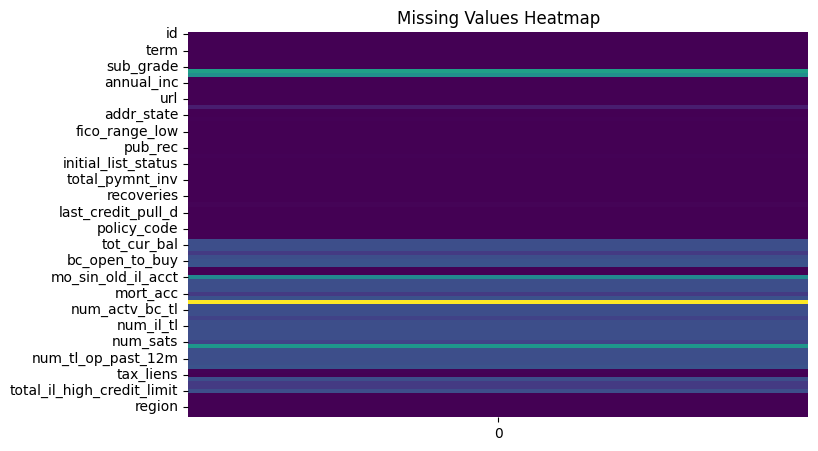

In [ ]:
# Plot columns with missing values
plt.figure(figsize=(8, 5))
sns.heatmap(accepted_cleaned.isnull().sum().to_frame(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [ ]:
accepted_cleaned = accepted_cleaned.dropna()

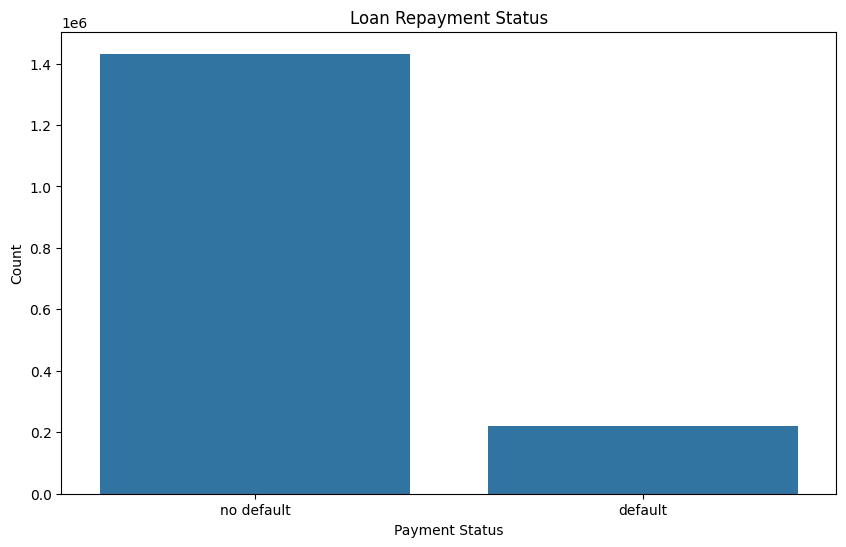

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='status_label', data=accepted_cleaned)
plt.title('Loan Repayment Status')
plt.xlabel('Payment Status')
plt.ylabel('Count')
plt.show()

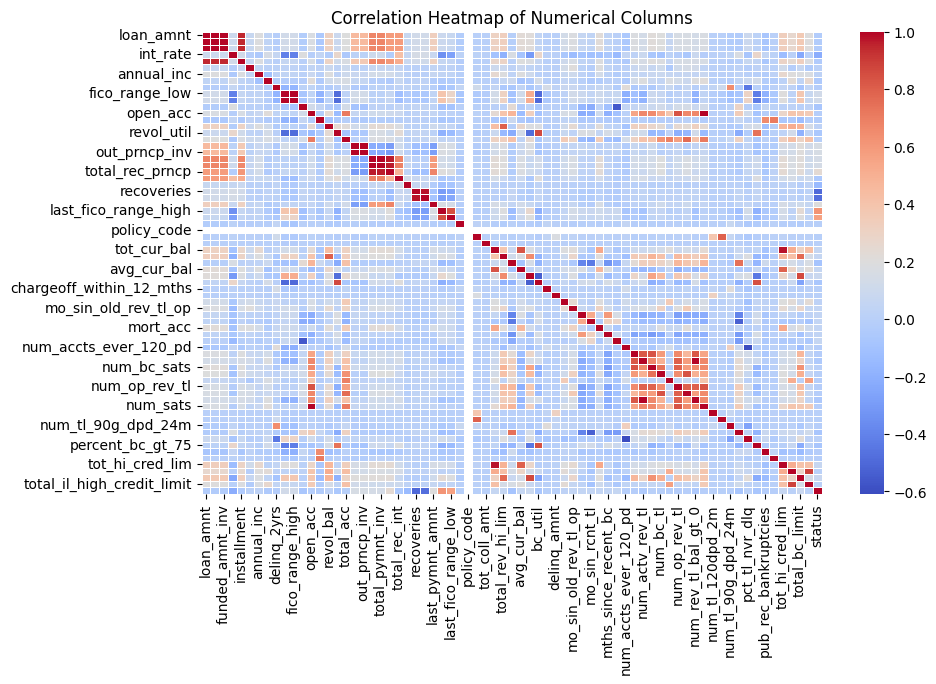

In [ ]:
num_cols = accepted_cleaned.select_dtypes(include=['number'])
plt.figure(figsize=(10, 6))
sns.heatmap(num_cols.corr(), annot = False, cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Columns')
plt.show()

### Is employment length a deciding factor to loan repayment?

Text(0, 0.5, 'Count')

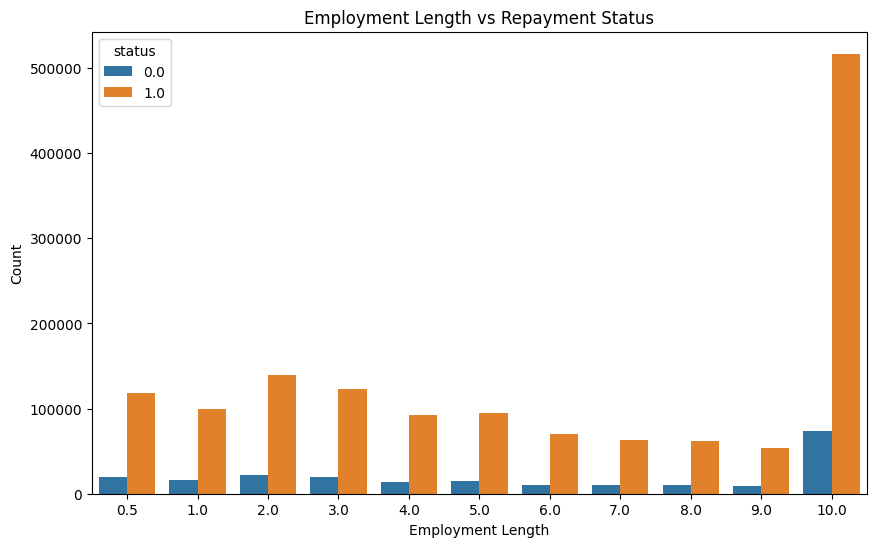

In [ ]:
# Plot the employment length against the date column
plt.figure(figsize=(10, 6))
sns.countplot(data=accepted_cleaned, x='emp_length', hue='status')
plt.title('Employment Length vs Repayment Status')
plt.xlabel('Employment Length')
plt.ylabel('Count')

Text(0.5, 0, 'Loan Amount')

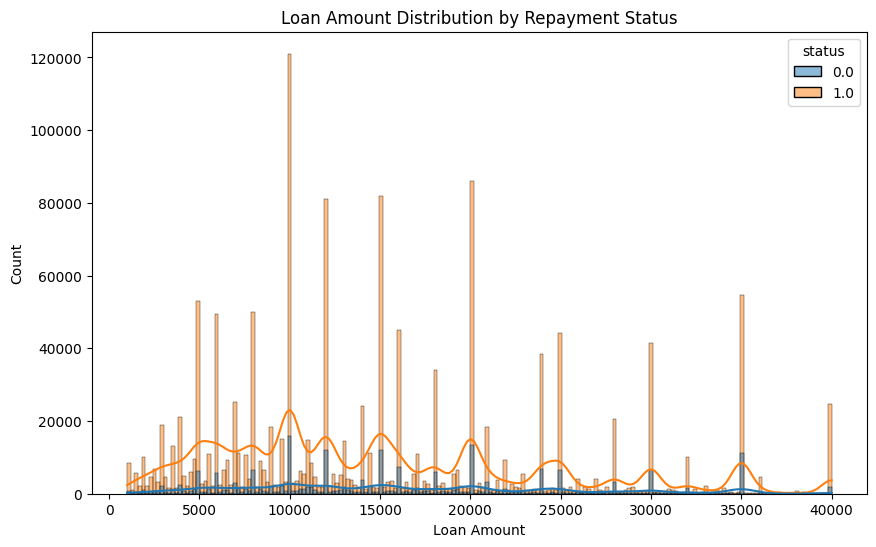

In [ ]:
# Plot the numerical columns using hisogram against the status
plt.figure(figsize=(10, 6))
sns.histplot(data=accepted_cleaned, x='loan_amnt', hue='status', kde=True)
plt.title('Loan Amount Distribution by Repayment Status')
plt.xlabel('Loan Amount')

#### Does employment length decide if a person should apply for loan or not?

Text(0.5, 0, 'Employment Length')

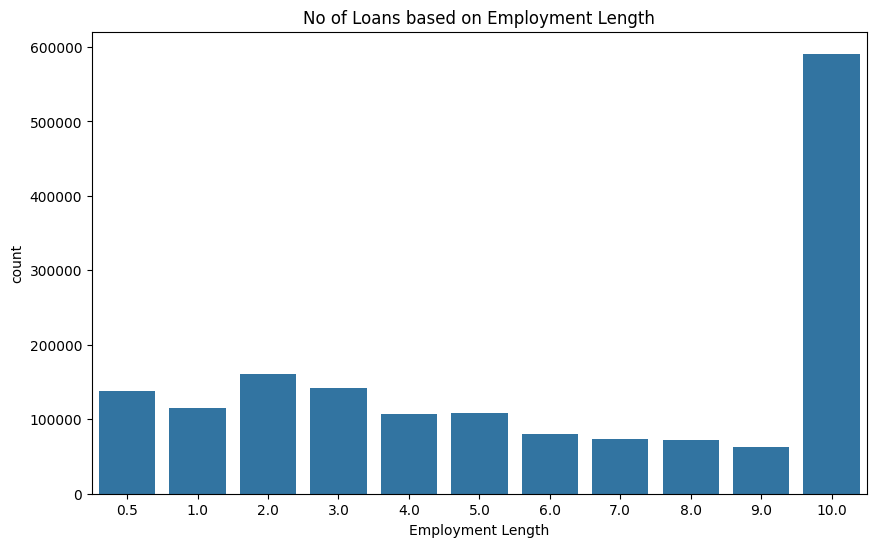

In [ ]:
# Plot employment length against the loan amount
plt.figure(figsize=(10, 6))
sns.countplot(data=accepted_cleaned, x='emp_length')
plt.title('No of Loans based on Employment Length')
plt.xlabel('Employment Length')

People with over 10 years of employment have the highest loan amount

Text(0, 0.5, 'Interest Rate')

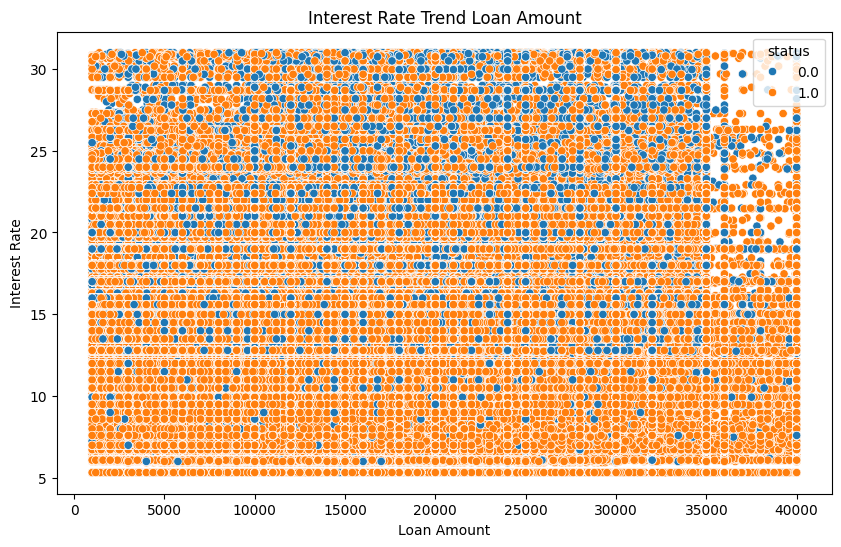

In [ ]:
# Plot a trendline of interest rate over years
plt.figure(figsize=(10, 6))
sns.scatterplot(data=accepted_cleaned, x='loan_amnt',
                y='int_rate', hue = 'status')
plt.title('Interest Rate Trend Loan Amount')
plt.xlabel('Loan Amount')
plt.ylabel('Interest Rate')

# **Feature Engineering**
### Check the feature importance of each column using LGBoost

In [ ]:
# Import lgb
import lightgbm as lgb

# Instantiate lgb with parameters
lgb_model = lgb.LGBMClassifier()

# Using label encoder; encode the categorical columns of the accepted_cleaned
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
encode_df = accepted_cleaned.copy()
cat_cols = accepted_cleaned.select_dtypes(include=['object', 'category']).columns

for col in cat_cols:
    encode_df[col] = le.fit_transform(accepted_cleaned[col])

# Drop original columns
accepted_cleaned = accepted_cleaned.drop(cat_cols, axis=1)

# Concatenate the encoded columns with the original DataFrame
accepted_cleaned = pd.concat([accepted_cleaned, encode_df[cat_cols]], axis=1)

# Split data into X and y
X = accepted_cleaned.drop(['status'], axis=1)
y = accepted_cleaned['status']

# split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit xgb to the training data
lgb_model.fit(X_train, y_train)

# Predict the labels of the test set
#preds = xgb.predict(X_test)

# Feature importance
importance = lgb_model.feature_importances_
accept_imp = pd.DataFrame({'feature': X.columns, 'importance': importance})
accept_imp = accept_imp.sort_values('importance', ascending=False)
accept_imp

[LightGBM] [Info] Number of positive: 1145299, number of negative: 176662
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.489015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11975
[LightGBM] [Info] Number of data points in the train set: 1321961, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.866364 -> initscore=1.869183
[LightGBM] [Info] Start training from score 1.869183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

,feature,importance
0,loan_amnt,225
3,int_rate,177
94,status_label,100
6,annual_inc,82
2,funded_amnt_inv,58
...,...,...
87,last_pymnt_d,0
90,hardship_flag,0
91,disbursement_method,0
92,debt_settlement_flag,0


In [ ]:
accept_imp.sort_values(by = 'importance', ascending = False).reset_index(drop = True)

,feature,importance
0,loan_amnt,225
1,int_rate,177
2,status_label,100
3,annual_inc,82
4,funded_amnt_inv,58
...,...,...
90,last_pymnt_d,0
91,hardship_flag,0
92,disbursement_method,0
93,debt_settlement_flag,0


In [ ]:
# Set a threshold of less than 5 and drop those columns
cols_d = accept_imp[accept_imp['importance'] < 5].index
lgb_d = accept_imp.drop(cols_d)
lgb_d.reset_index(drop = True)

,feature,importance
0,loan_amnt,225
1,int_rate,177
2,status_label,100
3,annual_inc,82
4,funded_amnt_inv,58
5,dti,20
6,total_rec_late_fee,18
7,revol_bal,15
8,out_prncp,13
9,mo_sin_old_il_acct,12


We will be using the features generated by lgb for our modeling as this gave more details on the dataset importance

In [ ]:
# Create a list of the features
imp_features = lgb_d['feature'].tolist()

# Add `status` to the created features
add_features = 'status'

# Use an if statement to append the add_features to imp_features
if add_features not in imp_features:
    imp_features.append(add_features)

# Create a dataframe that have only the important features
lending_df = accepted_cleaned[imp_features]
lending_df.head()

,loan_amnt,int_rate,status_label,annual_inc,funded_amnt_inv,dti,total_rec_late_fee,revol_bal,out_prncp,mo_sin_old_il_acct,...,last_pymnt_amnt,installment,mths_since_recent_bc,total_rev_hi_lim,avg_cur_bal,total_bal_ex_mort,mo_sin_rcnt_tl,total_rec_prncp,total_rec_int,status
0,3600.0,13.99,1,55000.0,3600.0,5.91,0.0,2765.0,0.0,148.0,...,122.67,123.03,4.0,9300.0,20701.0,7746.0,3.0,3600.0,821.72,1.0
1,24700.0,11.99,1,65000.0,24700.0,16.06,0.0,21470.0,0.0,113.0,...,926.35,820.28,2.0,111800.0,9733.0,39475.0,2.0,24700.0,979.66,1.0
4,10400.0,22.45,1,104433.0,10400.0,25.37,0.0,21929.0,0.0,128.0,...,10128.96,289.91,4.0,34000.0,27644.0,95768.0,4.0,10400.0,1340.50,1.0
6,20000.0,9.17,1,180000.0,20000.0,14.67,0.0,87329.0,0.0,142.0,...,15681.05,637.58,12.0,94200.0,30030.0,116762.0,10.0,20000.0,1393.80,1.0
7,20000.0,8.49,1,85000.0,20000.0,17.61,0.0,826.0,0.0,149.0,...,14618.23,631.26,32.0,14500.0,17700.0,27937.0,13.0,20000.0,1538.51,1.0


In [ ]:
lending_df.columns.tolist()

['loan_amnt',
 'int_rate',
 'status_label',
 'annual_inc',
 'funded_amnt_inv',
 'dti',
 'total_rec_late_fee',
 'revol_bal',
 'out_prncp',
 'mo_sin_old_il_acct',
 'revol_util',
 'total_pymnt',
 'tot_coll_amt',
 'last_pymnt_amnt',
 'installment',
 'mths_since_recent_bc',
 'total_rev_hi_lim',
 'avg_cur_bal',
 'total_bal_ex_mort',
 'mo_sin_rcnt_tl',
 'total_rec_prncp',
 'total_rec_int',
 'status']

## Machine Learning Model

* Import all the necessary libraries



In [ ]:
# Scale the dataset
scaler = StandardScaler()
X = lending_df.drop(columns = ['status', 'status_label'], axis=1)
y = lending_df['status']

## Use Deep Learning for Prediction